In [1]:
package_paths = [
    './pytorch-image-models', #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
    './FMix',
    './VisionTransformer-Pytorch'
]
import sys


for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask
from vision_transformer_pytorch import VisionTransformer

In [2]:
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from PIL import Image
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import warnings
warnings.filterwarnings('ignore')

/home/huang/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [3]:
CFG = {
    'fold_num': 5,
    'seed': 785,
    'model_arch': 'ViT-B_16',
    'img_size': 384,
    'epochs': 10,
    'train_bs': 32,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 1,
    'accum_iter': 1, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'label_smoothing':0.2
}

In [4]:
train = pd.read_csv('./data/train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [6]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,image_id,label
0,2216849948.jpg,4


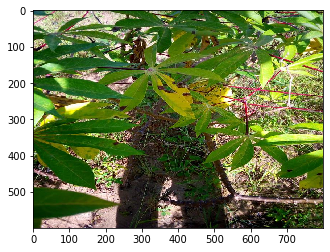

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('./data/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

In [8]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CassavaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
                
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))
                
                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

In [9]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            #Resize(CFG['img_size'], CFG['img_size']),
            #Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            #ShiftScaleRotate(p=0.5),
            #HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            #RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            #CoarseDropout(p=0.5),
            Cutout(p=0.3),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            #CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [10]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='./data/train_images'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels)
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    loss_sum = loss_sum/(step+1)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    val_acc = (image_preds_all==image_targets_all).mean()
    print('validation multi-class accuracy = {:.4f}'.format(val_acc))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return loss_sum, val_acc

In [11]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss
    
class LabelSmoothingCrossEntropy(nn.Module):
    """
    NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        """
        Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [12]:
# for training only, need nightly build pytorch
seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)

for fold, (trn_idx, val_idx) in enumerate(folds):
    # we'll train fold 0 first
    #if fold != 1:
    #    continue
        
    print('Training with {} started'.format(fold))

    print(len(trn_idx), len(val_idx))
    train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root='./data/train_images')

    device = torch.device(CFG['device'])
    
    lr = 1e-4

    model = timm.create_model('vit_base_patch16_384',pretrained=True,num_classes=5).to(device)
    #model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
    scaler = GradScaler()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=CFG['weight_decay'])
    #scheduler = torch.optim.lr_schedulerL.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
    #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max',factor=0.2, patience=1, verbose=True)

    loss_tr = LabelSmoothingCrossEntropy(smoothing=CFG['label_smoothing']).to(device) #MyCrossEntropyLoss().to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    init_epoch = 0
    max_lr_changes = 4
    valid_losses = []
    valid_acces = []
    lr_reset_epoch = init_epoch
    patience = 1
    lr_changes = 0
    best_valid_loss = 1000.
    best_valid_acc = 0.
    
    for epoch in range(CFG['epochs']):
        train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=None, schd_batch_update=False)
        
        with torch.no_grad():
            valid_loss, valid_acc = valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)
        '''
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(),'./models/{}_fold_{}_{}_{:.2f}'.format(CFG['model_arch'], fold, epoch, valid_loss))
        '''
        
        valid_acces.append(valid_acc)
        if best_valid_acc < valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(),'./models/{}_fold_{}_{}_{:.3f}'.format(CFG['model_arch'], fold, epoch, valid_acc))
        elif (patience and epoch - lr_reset_epoch > patience and
              max(valid_acces[-patience:]) < best_valid_acc):
            # "patience" epochs without improvement
            lr_changes +=1
            if lr_changes > max_lr_changes: # 早期停止
                break
            lr /= 5 # 学习率衰减
            print(f'lr updated to {lr}')
            lr_reset_epoch = epoch
            
        scheduler.step(valid_loss)
        
        valid_losses.append(valid_acc)
        
        valid_status = 'Epoch: {}\tLR: {:.6f}\tValid Loss: {:.4f}\tValid Acc: {:.4f}'.format(
            epoch, optimizer.state_dict()['param_groups'][0]['lr'], valid_loss, valid_acc)
        
        #with open('./logs/{}-log-fold{}.txt'.format(CFG['model_arch'], fold), 'a+') as f:
        #    f.write(valid_status+'\n')
        #    f.close()
        
        

    #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
    del model, optimizer, train_loader, val_loader, scaler, scheduler
    torch.cuda.empty_cache()

Training with 0 started
17115 4282



validation multi-class accuracy = 0.8641



validation multi-class accuracy = 0.8702



validation multi-class accuracy = 0.8723
Epoch     3: reducing learning rate of group 0 to 2.0000e-05.



validation multi-class accuracy = 0.8867



validation multi-class accuracy = 0.8830
lr updated to 2e-05
Epoch     5: reducing learning rate of group 0 to 4.0000e-06.



validation multi-class accuracy = 0.8877



validation multi-class accuracy = 0.8835
lr updated to 4.000000000000001e-06
Epoch     7: reducing learning rate of group 0 to 8.0000e-07.



validation multi-class accuracy = 0.8877



validation multi-class accuracy = 0.8877
Epoch     9: reducing learning rate of group 0 to 1.6000e-07.



validation multi-class accuracy = 0.8886
Training with 1 started
17116 4281



validation multi-class accuracy = 0.8568



validation multi-class accuracy = 0.8683



validation multi-class accuracy = 0.8697
Epoch     3: reducing learning rate of group 0 to 2.0000e-05.



validation multi-class accuracy = 0.8802



validation multi-class accuracy = 0.8755
lr updated to 2e-05
Epoch     5: reducing learning rate of group 0 to 4.0000e-06.



validation multi-class accuracy = 0.8827



validation multi-class accuracy = 0.8823
lr updated to 4.000000000000001e-06
Epoch     7: reducing learning rate of group 0 to 8.0000e-07.



validation multi-class accuracy = 0.8795



validation multi-class accuracy = 0.8729
lr updated to 8.000000000000002e-07
Epoch     9: reducing learning rate of group 0 to 1.6000e-07.



validation multi-class accuracy = 0.8823
Training with 2 started
17118 4279



validation multi-class accuracy = 0.8680



validation multi-class accuracy = 0.8717



validation multi-class accuracy = 0.8717
Epoch     3: reducing learning rate of group 0 to 2.0000e-05.



validation multi-class accuracy = 0.8885



validation multi-class accuracy = 0.8860
lr updated to 2e-05
Epoch     5: reducing learning rate of group 0 to 4.0000e-06.



validation multi-class accuracy = 0.8827



validation multi-class accuracy = 0.8850
lr updated to 4.000000000000001e-06
Epoch     7: reducing learning rate of group 0 to 8.0000e-07.



validation multi-class accuracy = 0.8904



validation multi-class accuracy = 0.8867
lr updated to 8.000000000000002e-07
Epoch     9: reducing learning rate of group 0 to 1.6000e-07.



validation multi-class accuracy = 0.8883
Training with 3 started
17119 4278



validation multi-class accuracy = 0.8282



validation multi-class accuracy = 0.8555



validation multi-class accuracy = 0.8679
Epoch     3: reducing learning rate of group 0 to 2.0000e-05.



validation multi-class accuracy = 0.8859



validation multi-class accuracy = 0.8827
lr updated to 2e-05
Epoch     5: reducing learning rate of group 0 to 4.0000e-06.



validation multi-class accuracy = 0.8850



validation multi-class accuracy = 0.8827
lr updated to 4.000000000000001e-06
Epoch     7: reducing learning rate of group 0 to 8.0000e-07.



validation multi-class accuracy = 0.8829



validation multi-class accuracy = 0.8815
lr updated to 8.000000000000002e-07
Epoch     9: reducing learning rate of group 0 to 1.6000e-07.



validation multi-class accuracy = 0.8864
Training with 4 started
17120 4277



validation multi-class accuracy = 0.8604



validation multi-class accuracy = 0.8611



validation multi-class accuracy = 0.8693
Epoch     3: reducing learning rate of group 0 to 2.0000e-05.



validation multi-class accuracy = 0.8805



validation multi-class accuracy = 0.8824
Epoch     5: reducing learning rate of group 0 to 4.0000e-06.



validation multi-class accuracy = 0.8815
lr updated to 2e-05



validation multi-class accuracy = 0.8819
Epoch     7: reducing learning rate of group 0 to 8.0000e-07.



validation multi-class accuracy = 0.8808
lr updated to 4.000000000000001e-06



validation multi-class accuracy = 0.8791
Epoch     9: reducing learning rate of group 0 to 1.6000e-07.



validation multi-class accuracy = 0.8845
